In [1]:
import pandas as pd

# Load the dataset
file_path = "asag_dataset.csv"
df = pd.read_csv(file_path)

# Display basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           646 non-null    int64  
 1   question             646 non-null    object 
 2   student_answer       607 non-null    object 
 3   grades_round         646 non-null    int64  
 4   student_modified     606 non-null    object 
 5   ref_answer           646 non-null    object 
 6   qn_modified          646 non-null    object 
 7   ref_modified         646 non-null    object 
 8   student_demoted      606 non-null    object 
 9   ref_demoted          646 non-null    object 
 10  length_ratio         646 non-null    float64
 11  embed_ref            646 non-null    object 
 12  embed_stud           646 non-null    object 
 13  embed_ref_demoted    646 non-null    object 
 14  embed_stud_demoted   646 non-null    object 
 15  aligned              646 non-null    obj

In [2]:
# df.head()
print(df.describe())
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)



       Unnamed: 0  grades_round  length_ratio  cos_similarity  \
count  646.000000    646.000000    646.000000      646.000000   
mean   322.500000      1.369969      0.252263        0.733258   
std    186.628419      0.724518      0.148225        0.212926   
min      0.000000      0.000000      0.000000        0.000000   
25%    161.250000      1.000000      0.161837        0.709271   
50%    322.500000      2.000000      0.233747        0.790438   
75%    483.750000      2.000000      0.327405        0.849242   
max    645.000000      2.000000      1.000000        1.000000   

       cos_similarity_demo  aligned_score  aligned_score_demo  question_id  
count           646.000000     646.000000          646.000000   646.000000  
mean              0.693964       0.364100            0.319602     9.000000  
std               0.210168       0.180216            0.175425     4.902776  
min               0.000000       0.000000            0.000000     1.000000  
25%               0.655392   

In [3]:
# Check for rows where 'student_modified' or 'student_demoted' are missing but 'student_answer' is not
discrepancy_rows = df[df['student_answer'].notnull() & (df['student_modified'].isnull() | df['student_demoted'].isnull())]
print("Rows where 'student_answer' is present but 'student_modified' or 'student_demoted' are missing:")
print(discrepancy_rows)

Rows where 'student_answer' is present but 'student_modified' or 'student_demoted' are missing:
     Unnamed: 0                                           question  \
555         555  What are three items to be learned for an RBF ...   

    student_answer  grades_round student_modified  \
555              -             0              NaN   

                                            ref_answer  \
555  Three items to be learned are centers, weights...   

                                           qn_modified  \
555  three item learned rbf network difference nns ...   

                                          ref_modified student_demoted  \
555  three item learned center weight bias rbfn con...             NaN   

                                           ref_demoted  ...  embed_stud  \
555  center weight bias rbfn consists single hidden...  ...         0.0   

                                     embed_ref_demoted embed_stud_demoted  \
555  [[ 0.61642578 -0.19705078  0.61673096  1

#### Improved Ensemble Results

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lanaa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Found 39 rows with missing student answers.
Assigning grade 0 to rows with missing student answers...
Extracting features...

Sample Preprocessed Data:
   length_diff  word_count_ratio  token_overlap  cosine_similarity  \
0         10.0          1.081967       0.436620           0.615858   
1         29.0          1.000000       0.391304           0.591311   
2        245.0          0.393443       0.213115           0.345962   
3        144.0          1.344262       0.087379           0.078630   
4         93.0          1.262295       0.273810           0.349066   

   jaccard_similarity     bleu_score  rouge_l_f1  tfidf_cosine_similarity  \
0            0.436620   2.520111e-01    0.576923                 0.615858   
1            0.391304   1.615273e-01    0.408163                 0.591311   
2            0.213115   2.830356e-02    0.373333                 0.345962   
3            0.087379  3.657213e-155    0.139130                 0.078630   
4            0.273810  4.967973e-155    0.

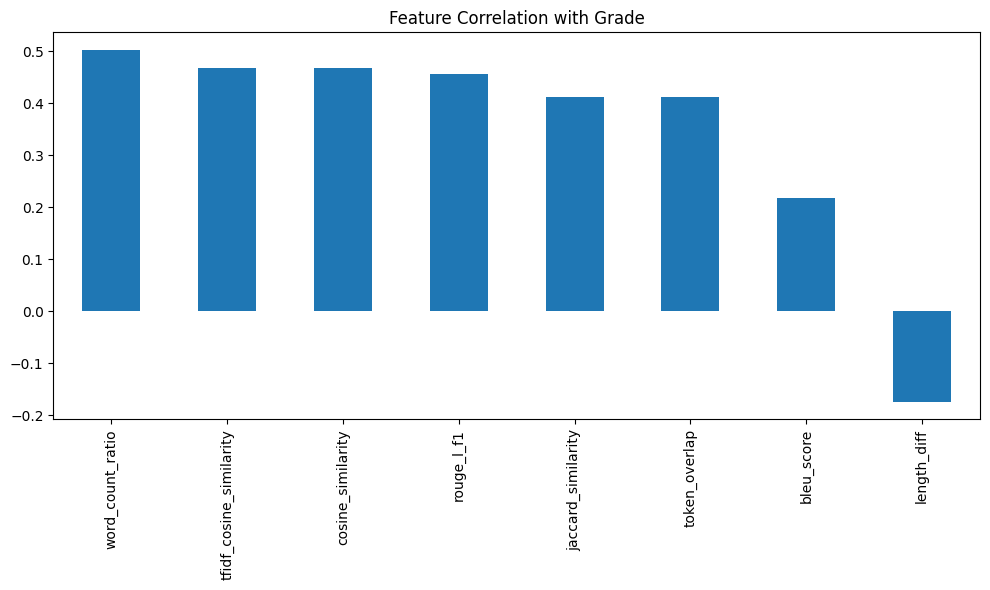

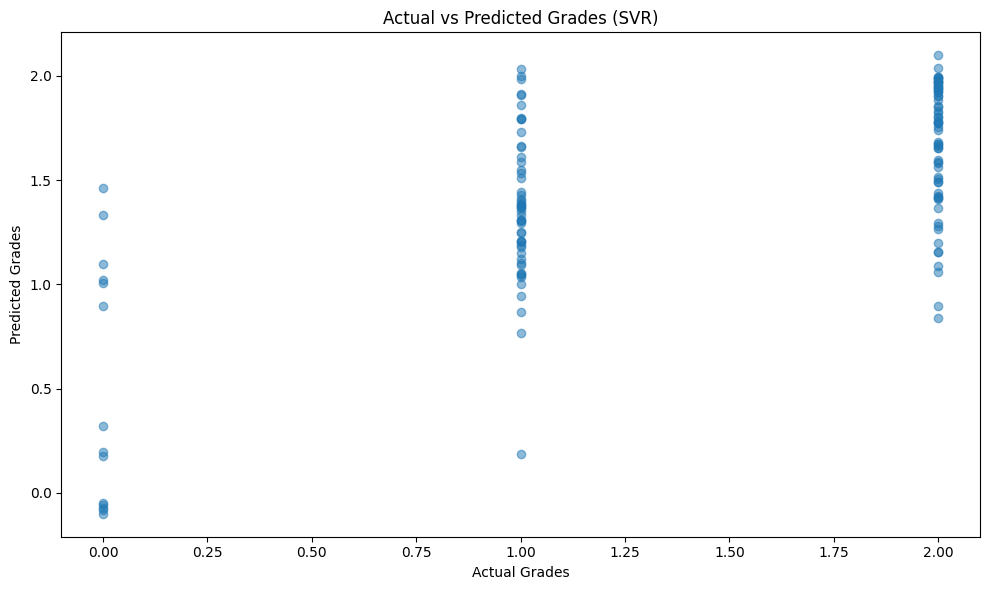

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
from sklearn.metrics import jaccard_score
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
warnings.filterwarnings('ignore')

# Download necessary NLTK packages
try:
    nltk.data.find('corpora/stopwords')
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('stopwords')
    nltk.download('punkt')
    nltk.download('wordnet')

def preprocess_text(text):
    """Advanced text preprocessing function"""
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Define a function to extract text features
def extract_text_features(ref_answers, stud_answers):
    """Extracts advanced features from reference and student answers."""
    features = []
    feature_names = [
        'length_diff', 
        'word_count_ratio', 
        'token_overlap', 
        'cosine_similarity',
        'jaccard_similarity',
        'bleu_score',
        'rouge_l_f1',
        'tfidf_cosine_similarity'
    ]
    
    # Initialize TF-IDF vectorizer once for all
    all_texts = ref_answers + stud_answers
    tfidf_vectorizer = TfidfVectorizer().fit(all_texts)
    
    # Initialize grammar checker
    # tool = language_tool_python.LanguageTool('en-US')
    
    rouge = Rouge()

    for ref, stud in zip(ref_answers, stud_answers):
        # Basic features
        ref_len = len(ref)
        stud_len = len(stud)
        length_diff = abs(ref_len - stud_len)
        
        ref_words = set(ref.lower().split())
        stud_words = set(stud.lower().split())
        token_overlap = len(ref_words & stud_words) / max(len(ref_words | stud_words), 1)
        
        word_count_ratio = len(stud.split()) / (len(ref.split()) + 1e-6)
        
        # Cosine similarity (simple bag-of-words vector)
        ref_vec = tfidf_vectorizer.transform([ref])
        stud_vec = tfidf_vectorizer.transform([stud])
        cosine_sim = (ref_vec @ stud_vec.T).A[0][0]
        
        # Jaccard similarity
        jaccard_sim = len(ref_words.intersection(stud_words)) / max(len(ref_words.union(stud_words)), 1)
        
        # BLEU score
        bleu = sentence_bleu([ref.split()], stud.split())
        
        # ROUGE-L F1 score
        try:
            rouge_score = rouge.get_scores(stud, ref)[0]['rouge-l']['f']
        except:
            rouge_score = 0.0  # fallback if rouge fails (empty strings, etc)
        
        # Grammar error count
        # matches = tool.check(stud)
        # grammar_errors = len(matches)
        
        # TF-IDF cosine similarity
        tfidf_cos_sim = cosine_sim
        
        # Collect all features
        features.append([
            length_diff,
            word_count_ratio,
            token_overlap,
            cosine_sim,
            jaccard_sim,
            bleu,
            rouge_score,
            tfidf_cos_sim
        ])
    
    return np.array(features), feature_names

def create_and_evaluate_models(X, y, feature_names):
    """Create, train and evaluate multiple models"""
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print("Splitting data into training and testing sets...")
    print(f"Training set size: {len(X_train)}")
    print(f"Testing set size: {len(X_test)}")
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create multiple models
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'ElasticNet': ElasticNet(),
        'SVR': SVR(),
        'Random Forest': RandomForestRegressor(random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(random_state=42)
    }
    
    # Dictionary to store results
    results = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test_scaled)
        
        # Evaluate
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        accuracy = (1 - (mae / np.mean(y_test))) * 100 if np.mean(y_test) > 0 else 0
        
        # Store results
        results[name] = {
            'model': model,
            'mae': mae,
            'mse': mse,
            'r2': r2,
            'predictions': y_pred
        }
        
        print(f"{name}:")
        print(f"  MSE: {mse:.3f}")
        print(f"  MAE: {mae:.3f}")
        print(f"  R²: {r2:.3f}")
        print()
    
    # Find the best model based on MAE
    best_model_name = min(results, key=lambda x: results[x]['mae'])
    print(f"Best Model: {best_model_name} with MAE: {results[best_model_name]['mae']:.3f}")
    
    # Feature importance for tree-based models
    if 'Random Forest' in results:
        rf_model = results['Random Forest']['model']
        importances = rf_model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        print("\nFeature Importance (Random Forest):")
        for i, idx in enumerate(indices):
            if i < len(feature_names):
                print(f"{feature_names[idx]}: {importances[idx]:.4f}")
    
    # Create ensemble model
    estimators = [(name, model['model']) for name, model in results.items() 
                 if name in ['SVR', 'Random Forest', 'Gradient Boosting']]
    
    ensemble = VotingRegressor(estimators)
    ensemble.fit(X_train_scaled, y_train)
    ensemble_pred = ensemble.predict(X_test_scaled)
    
    # Evaluate ensemble
    ensemble_mse = mean_squared_error(y_test, ensemble_pred)
    ensemble_mae = mean_absolute_error(y_test, ensemble_pred)
    ensemble_r2 = r2_score(y_test, ensemble_pred)
    
    print("\nEnsemble Model:")
    print(f"  MSE: {ensemble_mse:.3f}")
    print(f"  MAE: {ensemble_mae:.3f}")
    print(f"  R²: {ensemble_r2:.3f}")
    
    # Visualize predictions vs actual for the best model
    plt.figure(figsize=(10, 6))
    best_preds = results[best_model_name]['predictions']
    plt.scatter(y_test, best_preds, alpha=0.5)
    # plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Grades')
    plt.ylabel('Predicted Grades')
    plt.title(f'Actual vs Predicted Grades ({best_model_name})')
    plt.tight_layout()
    plt.savefig('prediction_vs_actual.png')
    
    # Error analysis
    errors = np.abs(y_test - best_preds)
    error_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': best_preds,
        'Error': errors
    })
    
    print("\nWorst Predictions:")
    print(error_df.sort_values('Error', ascending=False).head(5))
    
    # Perform hyperparameter tuning for the top model on training data only
    print("\nPerforming hyperparameter tuning on training data...")
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                              cv=5, n_jobs=-1, scoring='neg_mean_absolute_error')
    # Use only training data for hyperparameter tuning
    grid_search.fit(X_train_scaled, y_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best MAE: {-grid_search.best_score_:.3f}")
    
    # Create the best model with tuned hyperparameters
    best_rf = RandomForestRegressor(**grid_search.best_params_, random_state=42)
    best_rf.fit(X_train_scaled, y_train)
    
    # Evaluate the tuned model on test data
    tuned_preds = best_rf.predict(X_test_scaled)
    tuned_mse = mean_squared_error(y_test, tuned_preds)
    tuned_mae = mean_absolute_error(y_test, tuned_preds)
    tuned_r2 = r2_score(y_test, tuned_preds)
    
    print("\nTuned Random Forest on Test Data:")
    print(f"  MSE: {tuned_mse:.3f}")
    print(f"  MAE: {tuned_mae:.3f}")
    print(f"  R²: {tuned_r2:.3f}")
    
    # Cross-validation on training data only
    print("\nPerforming cross-validation on training data...")
    cv_scores = cross_val_score(best_rf, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
    print(f"Cross-validation MAE: {-np.mean(cv_scores):.3f} ± {np.std(cv_scores):.3f}")
    
    return results, best_rf, ensemble, scaler, X_test, y_test

def main(df):
    """Main function that ties everything together"""
    
    '''
    # Ensure required columns exist
    required_columns = {'ref_answer', 'student_answer', 'grades_round'}
    if not required_columns.issubset(df.columns):
        raise KeyError(f"Missing columns: {required_columns - set(df.columns)}")
    
    # OPTION 1: Remove rows with missing student answers
    missing_count = df['student_answer'].isna().sum()
    if missing_count > 0:
        print(f"Found {missing_count} rows with missing student answers.")
        print("Removing rows with missing student answers...")
        df = df.dropna(subset=['student_answer'])
        print(f"Remaining rows: {len(df)}")

    '''
    
    # OPTION 2: Replace missing student answers with empty string and assign grade 0
    # Uncomment the following lines to use this approach instead
    
    missing_count = df['student_answer'].isna().sum()
    if missing_count > 0:
        print(f"Found {missing_count} rows with missing student answers.")
        print("Assigning grade 0 to rows with missing student answers...")
        # First, save original grades for missing answers (in case they weren't 0)
        original_grades = df.loc[df['student_answer'].isna(), 'grades_round'].copy()
        if not all(original_grades == 0):
            print(f"Warning: {(original_grades != 0).sum()} missing answers had non-zero grades.")
        
        # Replace missing answers with empty string and set grade to 0
        df.loc[df['student_answer'].isna(), 'student_answer'] = ""
        df.loc[df['student_answer'] == "", 'grades_round'] = 0
    
    
    # Extract necessary columns
    ref_answers = df['ref_answer'].values
    stud_answers = df['student_answer'].values
    grades = df['grades_round'].astype(float).values

    print("Extracting features...")
    X, feature_names = extract_text_features(ref_answers, stud_answers)
    # Convert features to DataFrame for display/export
    preprocessed_df = pd.DataFrame(X, columns=feature_names)
    preprocessed_df['grade'] = grades

    # Print the first few rows
    print("\nSample Preprocessed Data:")
    print(preprocessed_df.head())
    
    # Analyze feature correlations
    feature_df = pd.DataFrame(X, columns=feature_names)
    feature_df['grade'] = grades
    
    # Display correlation with grade
    correlations = feature_df.corr()['grade'].sort_values(ascending=False)
    print("\nFeature Correlations with Grade:")
    print(correlations)
    
    # Visualize top correlations
    plt.figure(figsize=(10, 6))
    correlations.drop('grade').sort_values(ascending=False).plot(kind='bar')
    plt.title('Feature Correlation with Grade')
    plt.tight_layout()
    plt.savefig('feature_correlations.png')
    
    # Train and evaluate models
    print("\nTraining and evaluating models...")
    results, best_rf, ensemble, scaler, X_test, y_test = create_and_evaluate_models(X, grades, feature_names)
    
        # Define a function for grading new answers
    def grade_new_answer(ref_answer, student_answer, model=best_rf, feat_scaler=scaler):
        """Grade a new student answer based on a reference answer"""
        # Extract features
        features, _ = extract_text_features([ref_answer], [student_answer])
        
        # Scale features
        scaled_features = feat_scaler.transform(features)
        
        # Predict grade
        predicted_grade = model.predict(scaled_features)[0]
        
        # Ensure grade is within valid range (assuming 0-100)
        predicted_grade = max(0, min(100, predicted_grade))
        
        return predicted_grade
    
    # Example usage
    if len(ref_answers) > 0 and len(stud_answers) > 0:
        example_ref = ref_answers[0]
        example_stud = stud_answers[0]
        predicted_grade = grade_new_answer(example_ref, example_stud)
        print(f"\nExample Grading:")
        print(f"Reference Answer: {example_ref[:100]}...")
        print(f"Student Answer: {example_stud[:100]}...")
        print(f"Actual Grade: {grades[0]}")
        print(f"Predicted Grade: {predicted_grade:.2f}")
    
    # Return the best model and preprocessing tools
    return {
        'best_rf_model': best_rf,
        'ensemble_model': ensemble,
        'scaler': scaler,
        'feature_extractor': extract_text_features,
        'grade_function': grade_new_answer
    }

# Example usage
if __name__ == "__main__":
    # Assuming df is already loaded
    df = pd.read_csv('asag_dataset.csv')
    results = main(df)